# NYC Capital Projects

## Notebook 04: BERT Embedding Dimensionality Reduction using PCA and an Autoencoder Network

In this notebook, an autoencoder neural network and PCA decomposition are both separately trained on our training data textual description embeddings, reducing the embeddings to two different bottlenecked 2-dimensional latent spaces.

The purpose of this will be to convert the 512 dimension Bert embeddings of our textual project descriptions to an encoded 2-dimensional feature we can use while training and testing our models. PCA decomposition and autoencoder latent space encoding are being used as two competing methods to accomplish this task. During modeling, we will determine which method of encoding yields better predictive power for our finished models and use that method.

### Project authors

- [An Hoang](https://github.com/hoangthienan95)
- [Mark McDonald](https://github.com/mcdomx)
- [Mike Sedelmeyer](https://github.com/sedelmeyer)


### Inputs:

The following files are required to successfully run this notebook.

- ``../data/interim/embeddings_uncased_L-2_H-128_A-2.csv``

    The BERT embeddings for each capital project's textual description.
    

- ``../data/interim/NYC_capital_projects_3yr_train.csv``

    The training split of our 3-year interval subsetted project data.


- ``../data/interim/NYC_capital_projects_3yr_test.csv``

    The test split of our 3-year interval subsetted project data.


### Outputs:

The following files are generated by executing the code in this notebook.

**Data files**

- ``../data/interim/ae_pca_encoded_embed_train.csv``

    The PCA and autoencoder 2-dimensional feature values corresponding to each project record in our 3-year training split.


- ``../data/interim/ae_pca_encoded_embed_test.csv``

    The PCA and autoencoder 2-dimensional feature values corresponding to each project record in our 3-year test split.


**Tensorflow Keras autoencoder saved models**

- ``../models/ae_descr_embed_encode``

    The trained autoencoder "encoder" network.
    

- ``../models/ae_descr_embed_decode``

    The trained autoencoder "decoder" network.
    

- ``../models/ae_descr_embed_full_ae``

    The trained autoencoder full encoder and decoder combined network.
    

- ``../models/ae_descr_embed_history.pickle``

    The autoencoder training loss history measured at the end of each epoch.


**Scikit-learn PCA model, saved via `pickle`**

- ``../models/pca_descr_embed.pickle``

    The fitted PCA scikit-learn model.

# Notebook contents

1. [Import libraries and load data](#Import-libraries-and-load-data)

2. [Define functions for plotting and keras architecture](#Define-functions-for-plotting-and-keras-architecture)

3. [Build and fit dense autoencoder with 2-dimensional bottleneck](#Build-and-fit-dense-autoencoder-with-2-dimensional-bottleneck)

4. [Build and fit dense autoencoder with 1-dimensional bottleneck](#Build-and-fit-dense-autoencoder-with-1-dimensional-bottleneck)

5. [Fit PCA decomposition with 2 components](#Fit-PCA-decomposition-with-2-components)

6. [Generate encoded embeddings for train and test using each method](#Generate-encoded-embeddings-for-train-and-test-using-each-method)

7. [Plot resulting encoded embeddings for each method](#Plot-resulting-encoded-embeddings-for-each-method)

8. [Save resulting models and feature data](#Save-resulting-models-and-feature-data)

# Import libraries and load data

[Return to top](#Notebook-contents)

In [1]:
random_seed = 109

from numpy.random import seed
seed(random_seed)

import tensorflow as tf
tf.random.set_seed(random_seed)

In [2]:
import os
import pickle

import numpy as np
import pandas as pd
import seaborn as sns

from matplotlib import pyplot
import matplotlib.pylab as plt 
%matplotlib inline

from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error

from tensorflow.keras import Input
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam

In [3]:
filepath_embed = '../data/interim/embeddings_uncased_L-2_H-128_A-2.csv'
filepath_train = '../data/interim/NYC_capital_projects_3yr_train.csv'
filepath_test = '../data/interim/NYC_capital_projects_3yr_test.csv'

savedata_train = '../data/interim/ae_pca_encoded_embed_train.csv'
savedata_test = '../data/interim/ae_pca_encoded_embed_test.csv'

savemodel_ae_hist = '../models/ae_descr_embed_history.pickle'
savemodel_ae_encode = '../models/ae_descr_embed_encode'
savemodel_ae_decode = '../models/ae_descr_embed_decode'
savemodel_ae = '../models/ae_descr_embed_full_ae'
savemodel_pca = '../models/pca_descr_embed.pickle'

if os.path.isfile(filepath_embed):
    print("OK - path points to file.")
else:
    print("ERROR - check the 'file_path' and ensure it points to the source file.")

OK - path points to file.


In [4]:
data_embed = pd.read_csv(filepath_embed)
data_train = pd.read_csv(filepath_train)
data_test = pd.read_csv(filepath_test)

In [5]:
# entries
print(f"Number of dataset records: {len(data_embed)}")

# num projects
print(f"Number of unique projects in dataset: {len(data_embed['PID'].unique())}")

Number of dataset records: 355
Number of unique projects in dataset: 355


In [6]:
data_embed.info()

data_embed.head(3)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 355 entries, 0 to 354
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   PID        355 non-null    int64 
 1   embedding  355 non-null    object
dtypes: int64(1), object(1)
memory usage: 5.7+ KB


,PID,embedding
0,3,"-0.13854653, 1.4585932, -6.7886453, 0.06109361..."
1,7,"-0.13127574, 1.1954153, -6.7207437, 0.06122951..."
2,18,"0.09863796, 1.6704285, -6.5727553, 0.06882739,..."


In [7]:
# dedupe dataframe by keeping first occurance of each PID
data_embed = data_embed.copy().drop_duplicates(subset='PID', keep='first')

In [8]:
# entries
print(f"Number of dataset records: {len(data_embed)}")

# num projects
print(f"Number of unique projects in dataset: {len(data_embed['PID'].unique())}")

Number of dataset records: 355
Number of unique projects in dataset: 355


In [9]:
# split embedding data into train/test splits

# identify PIDs in train and test sets
train_pids = data_train['PID'].values
test_pids = data_test['PID'].values

# used those PIDs to create two subsetted versions of the embed data
embed_train = data_embed.set_index('PID').copy().loc[train_pids]
embed_test = data_embed.set_index('PID').copy().loc[test_pids]

In [10]:
train_pids.shape, embed_train.shape, test_pids.shape, embed_test.shape

((134,), (134, 1), (15,), (15, 1))

In [11]:
# generate embeddings train and test embedding value arrays

# save index keys for both embedding sets just in case
pid_key_train = embed_train.index
pid_key_test = embed_test.index

# extract embedding values from comma separated strings and convert to matrix 
embed_array_train = np.vstack(
    embed_train['embedding'].str.split(',').apply(
        lambda x: np.array(x).astype(float)
    ).values
)

embed_array_test = np.vstack(
    embed_test['embedding'].str.split(',').apply(
        lambda x: np.array(x).astype(float)
    ).values
)

# check shapes and types of resulting arrays
embed_array_train.shape, embed_array_train.dtype, embed_array_test.shape, embed_array_test.dtype

((134, 512), dtype('float64'), (15, 512), dtype('float64'))

# Define functions for plotting and keras architecture

[Return to top](#Notebook-contents)

In [12]:
# define function for plotting train vs val loss history by epoch

def plot_history(history, title, val_name='validation', loss_type='MSE'):
    """Plot training and validation loss using keras history object

    :param history: keras training history object or dict. If a dict is
                    used, it must have two keys named 'loss' and 'val_loss'
                    for which the corresponding values must be lists or
                    arrays with float values
    :param title: string, the title of the resulting plot
    :param val_name: string, the name for the val_loss line in the plot
                     legend (default 'validation')
    :param loss_type: string, the loss type name to be printed as the
                      y axis label (default 'MSE')
    :return: a line plot illustrating model training history, no
             objects are returned
    """
    n_epochs = len(history.history['loss'])
    x_vals = np.arange(1, n_epochs+1)
    
    # adjust interval of x_ticks based on n_epochs
    if n_epochs<40:
        x_ticks = x_vals
    elif n_epochs<140:
        x_ticks = np.arange(0, n_epochs+1, 5)
    else:
        x_ticks = np.arange(0, n_epochs+1, 10)
    
    fig, ax = plt.subplots(1, 1, figsize=(12, 5))

    plt.suptitle('{}'.format(title), fontsize=18)
        
    ax.plot(x_vals, history.history['loss'], 'k--', label='training')
    ax.plot(x_vals, history.history['val_loss'], 'k-', label=val_name)
    ax.set_xlabel('epoch', fontsize=14)
    ax.set_ylabel('loss ({})'.format(loss_type), fontsize=14)
    ax.set_xticks(x_ticks)
    ax.grid(':', alpha=0.4)
    ax.tick_params(labelsize=12)        
    
    plt.legend(fontsize=14)
    plt.tight_layout(rect=[0, 0.03, 1, .9])
    plt.show()

    
def plot_2d_embed_scatter(data1, data2, title, xlabel, ylabel,
                          data1_name='training obs', data2_name='TEST obs'):
    """Plots 2D scatterplot of dimension-reduced embeddings for train and test

    2D matplotlib scatterplot, no objects are returned.

    NOTE: This function assumes the data inputs are 2D np.array objects of
          share (n, 2), and that two separate sets of encoded embeddings
          are going to be plotted together (i.e. the train and the test
          observations). 2D pd.DataFrame objects can be passed, and are
          converted to np.array within the plotting function.

    :param data1: np.array 2D containing 2 encoded dimensions
    :param data2: a second np.array 2D containing 2 encoded dimensions
    :param title: str, text used for plot title
    :param xlabel: string representing the label for the x axis
    :param ylabel: string representing the label for the y axis
    :param data1_name: string representing the name of the first dataset,
                  this will be the label given to those points in the
                  plot's legend (default 'training obs')
    :param data2_name: string representing the name of the first dataset,
                  this will be the label given to those points in the
                  plot's legend (default 'TEST obs')
    """
    fig, ax = plt.subplots(figsize=(12, 5))
    plt.title(
        title,
        fontsize=18
    )
    plt.scatter(*data1.T,  color='silver', alpha=1, label=data1_name)
    plt.scatter(*data2.T, color='k', alpha=1, label=data2_name)
    plt.ylabel(ylabel, fontsize=14)
    plt.xlabel(xlabel, fontsize=14)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.grid(':', alpha=0.4)
    plt.legend(fontsize=12)
    plt.tight_layout()
    plt.show()
    
    
def plot_1d_embed_hist(data1, data2, title, xlabel, logscale=True,
                       data1_name='training obs', data2_name='TEST obs'):
    """Plot histograms of 1-dimensional encodings for train and test sets 
    """
    fig, ax = plt.subplots(figsize=(12, 4.5))
    plt.title(
        title,
        fontsize=18
    )
    plt.hist(*data1.T, color='silver', alpha=1, label=data1_name)
    plt.hist(*data2.T, color='k', alpha=1, label=data2_name)
    if logscale:
        plt.yscale('log')
        plt.ylabel('frequency (log scale)', fontsize=14)
    else:
        plt.ylabel('frequency', fontsize=14)
    plt.xlabel(xlabel, fontsize=14)
    plt.xticks(fontsize=12)
    plt.grid(':', alpha=0.4)
    plt.legend(fontsize=12)
    plt.tight_layout()
    plt.show()

In [13]:
def build_dense_ae_architecture(input_dim, encoding_dim, droprate, learning_rate, name):
    """Builds and compiles a tensorflow.keras dense autoencoder network

    NOTE:

       This network architecture was designed for the specific purpose of
       encoding a dataset of 1D embeddings. Therefore, the input dimension
       must be 1D with a length that equals the number of values in any
       single observation's embedding

    :param input_dim: integer, the length of each embedding (must all be of
                      the same length)
    :param encoding_dim: integer, the desired bottleneck dimension for the
                         encoder network
    :param droprate: float >0 <1, this is passed to the rate argument for
                     the dropout layers between each dense layer
    :param learning_rate: float, the desired learning rate for the Adam
                          optimizer used while compiling the model
    :param name: string, the desired name of the resulting network
    :return: tuple of 3 tf.keras model object, [0] full autoencoder model,
             [1] encoder model, [2] decoder model
    """
    # define encoder model
    input_layer = Input(shape=input_dim)
    
    encoded = Dense(encoding_dim*256, activation='relu', use_bias=True)(input_layer)
    encoded = Dropout(rate=droprate)(encoded)
    encoded = Dense(encoding_dim*64, activation='relu', use_bias=True)(encoded)
    encoded = Dropout(rate=droprate)(encoded)
    encoded = Dense(encoding_dim*16, activation='relu', use_bias=True)(encoded)
    encoded = Dropout(rate=droprate)(encoded)
    encoded = Dense(encoding_dim*4, activation='relu', use_bias=True)(encoded)
    encoded = Dropout(rate=droprate)(encoded)
    encoded = Dense(encoding_dim, activation='linear', use_bias=True)(encoded)
    
    encoder = Model(input_layer, encoded, name='{}_encoder'.format(name))

    # define decoder model
    latent_input = Input(shape=(encoding_dim,))
    
    decoded = Dense(encoding_dim*4, activation='relu', use_bias=True)(latent_input)
    decoded = Dropout(rate=droprate)(decoded)
    decoded = Dense(encoding_dim*16, activation='relu', use_bias=True)(decoded)
    decoded = Dropout(rate=droprate)(decoded)
    decoded = Dense(encoding_dim*64, activation='relu', use_bias=True)(decoded)
    decoded = Dropout(rate=droprate)(decoded)
    decoded = Dense(encoding_dim*256, activation='relu', use_bias=True)(decoded)
    decoded = Dropout(rate=droprate)(decoded)
    decoded = Dense(input_dim, activation='linear', use_bias=True)(decoded)
    
    decoder = Model(latent_input, decoded, name='{}_decoder'.format(name))

    # define full non-linear autoencoder model
    ae = Sequential(
        [
            encoder,
            decoder,
        ], name=name
    )

    # set loss, optimizer, and compile model
    loss = tf.keras.losses.mean_squared_error
    optimizer = Adam(lr=learning_rate)

    ae.compile(
        loss=loss,
        optimizer=optimizer
    )

    return ae, encoder, decoder


# Build and fit dense autoencoder with 2-dimensional bottleneck

[Return to top](#Notebook-contents)


THE ENCODER MODEL:

Model: "ae_2dim_encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 512)]             0         
_________________________________________________________________
dense (Dense)                (None, 512)               262656    
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               65664     
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 32)                4128      
_________________________________________________________________
dropout_2 (Dropout)          (

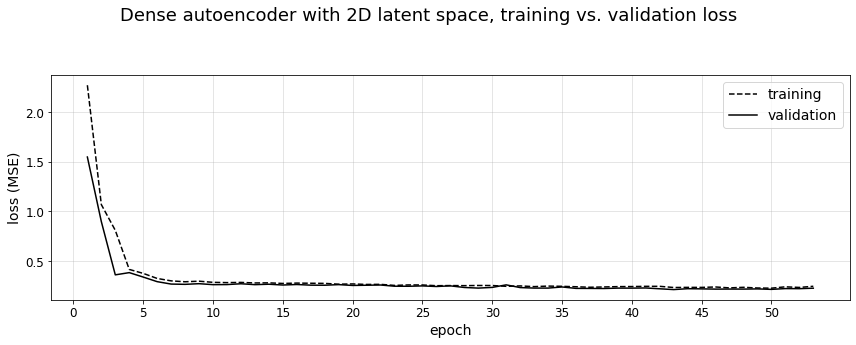

CPU times: user 5.27 s, sys: 1.04 s, total: 6.31 s
Wall time: 7.06 s


In [14]:
%%time

seed(random_seed)
tf.random.set_seed(random_seed)

# set input and encoded latent dimensions
input_dim = embed_array_train.shape[1]
encoding_dim = 2
droprate = 0.2
learning_rate = 0.005
name = 'ae_2dim'

ae2, encoder2, decoder2 = build_dense_ae_architecture(
    input_dim, encoding_dim, droprate, learning_rate, name
)

# print summaries of each model
print('\nTHE ENCODER MODEL:\n')
encoder2.summary()
print('\n\nTHE DECODER MODEL:\n')
decoder2.summary()
print('\n\nTHE AUTOENCODER (AE) MODEL:\n')
ae2.summary()
print('\n')


# set my parameters for training the model
verbose = 0
epochs = 200 # note my use of early-stopping to end training at suitable epoch
batch_size = 16

# callback for early stopping when epochs fail to yield val_loss improvements
callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', min_delta=0.0001, patience=10, verbose=1,
    restore_best_weights=True
)


# Fit model using x_test as validation data and self for measuring loss
ae2_history = ae2.fit(
    x=embed_array_train,
    y=embed_array_train,
    epochs=epochs,
    batch_size=batch_size,
    shuffle=True,
    callbacks=[callback],
    validation_data=(embed_array_train, embed_array_train),
    verbose=verbose
)

# plot the training vs validation loss 
plot_history(
    ae2_history,
    'Dense autoencoder with 2D latent space, training vs. validation loss',
    loss_type='MSE'
)

# Build and fit dense autoencoder with 1-dimensional bottleneck

[Return to top](#Notebook-contents)


THE ENCODER MODEL:

Model: "ae_1dim_encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 512)]             0         
_________________________________________________________________
dense_10 (Dense)             (None, 256)               131328    
_________________________________________________________________
dropout_8 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_11 (Dense)             (None, 64)                16448     
_________________________________________________________________
dropout_9 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_12 (Dense)             (None, 16)                1040      
_________________________________________________________________
dropout_10 (Dropout)         (

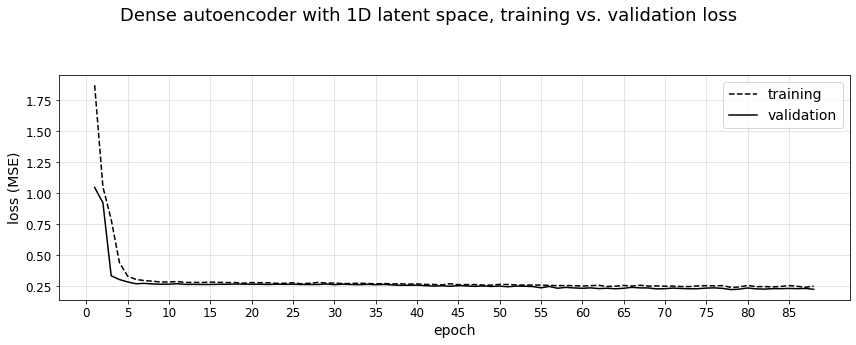

CPU times: user 5.92 s, sys: 498 ms, total: 6.42 s
Wall time: 4.76 s


In [15]:
%%time

seed(random_seed)
tf.random.set_seed(random_seed)

# set input and encoded latent dimensions
input_dim = embed_array_train.shape[1]
encoding_dim = 1
droprate = 0.2
learning_rate = 0.005
name = 'ae_1dim'

ae1, encoder1, decoder1 = build_dense_ae_architecture(
    input_dim, encoding_dim, droprate, learning_rate, name
)

# print summaries of each model
print('\nTHE ENCODER MODEL:\n')
encoder1.summary()
print('\n\nTHE DECODER MODEL:\n')
decoder1.summary()
print('\n\nTHE AUTOENCODER (AE) MODEL:\n')
ae1.summary()
print('\n')

# set my parameters for training the model
verbose = 0
epochs = 200 # note my use of early-stopping to end training at suitable epoch
batch_size = 16

# callback for early stopping when epochs fail to yield val_loss improvements
callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', min_delta=0.0001, patience=10, verbose=1,
    restore_best_weights=True
)


# Fit model using x_test as validation data and self for measuring loss
ae1_history = ae1.fit(
    x=embed_array_train,
    y=embed_array_train,
    epochs=epochs,
    batch_size=batch_size,
    shuffle=True,
    callbacks=[callback],
    validation_data=(embed_array_train, embed_array_train),
    verbose=verbose
)

# plot the training vs validation loss 
plot_history(
    ae1_history,
    'Dense autoencoder with 1D latent space, training vs. validation loss',
    loss_type='MSE'
)

# Fit PCA decomposition with 2 components

[Return to top](#Notebook-contents)

In [16]:
# generate PCA reduction
PCA_embed = PCA(
    n_components=2, random_state=random_seed
).fit(embed_array_train)

pca_expvar = PCA_embed.explained_variance_ratio_
total_expvar = pca_expvar.sum()

print(
    'PCA decomposition fitted on training data embeddings.\n\n'\
    'Total variance explained by the first 2 PCA compoenents: {:.2%}'\
    '\n'.format(total_expvar)
)

PCA decomposition fitted on training data embeddings.

Total variance explained by the first 2 PCA compoenents: 31.64%



# Generate encoded embeddings for train and test using each method

[Return to top](#Notebook-contents)

In [17]:
# generate AE 2D latent embeddings
ae2_latent_train = encoder2.predict(embed_array_train)
ae2_latent_test = encoder2.predict(embed_array_test)

# generate AE 1D latent embeddings
ae1_latent_train = encoder1.predict(embed_array_train)
ae1_latent_test = encoder1.predict(embed_array_test)

# generate PCA latent embeddings
pca_embed_train = PCA_embed.transform(embed_array_train)
pca_embed_test = PCA_embed.transform(embed_array_test)


# Plot resulting encoded embeddings for each method

[Return to top](#Notebook-contents)

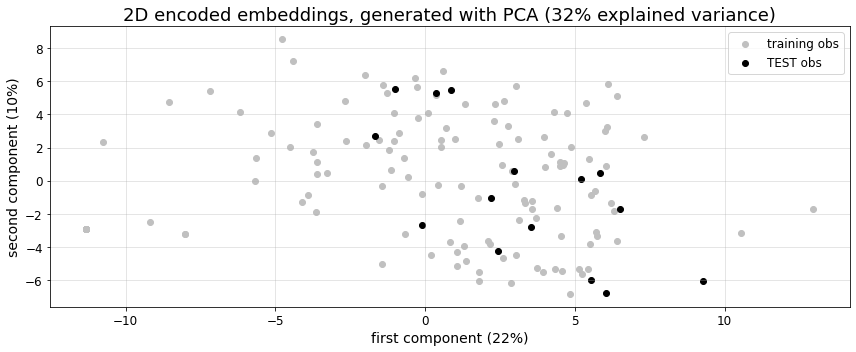

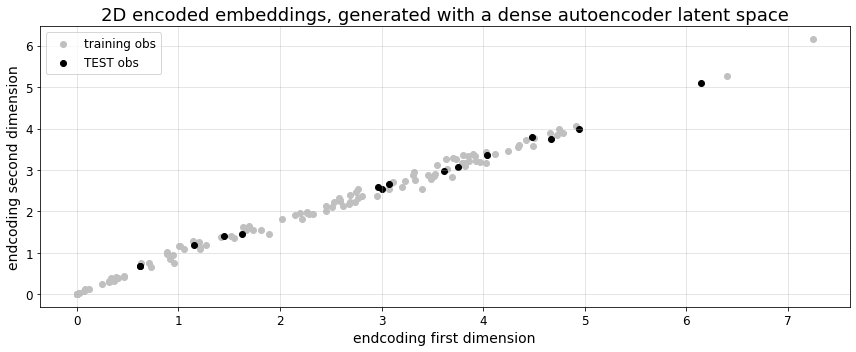

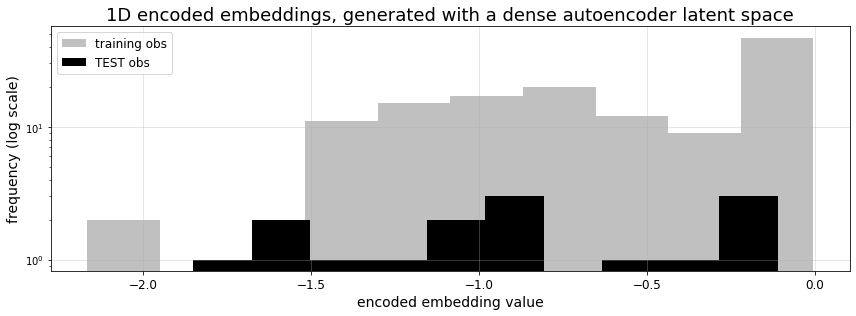

In [18]:
title = '2D encoded embeddings, generated with PCA '\
        '({:.0%} explained variance)'.format(total_expvar)
xlabel = 'first component ({:.0%})'.format(pca_expvar[0])
ylabel = 'second component ({:.0%})'.format(pca_expvar[1])

plot_2d_embed_scatter(pca_embed_train, pca_embed_test, title, xlabel, ylabel)

title = '2D encoded embeddings, generated with a dense autoencoder latent space'
xlabel = 'endcoding first dimension'
ylabel = 'endcoding second dimension'

plot_2d_embed_scatter(ae2_latent_train, ae2_latent_test, title, xlabel, ylabel)

title = '1D encoded embeddings, generated with a dense autoencoder latent space'
xlabel = 'encoded embedding value'

plot_1d_embed_hist(ae1_latent_train, ae1_latent_test, title, xlabel, logscale=True)

# Save resulting models and feature data

[Return to top](#Notebook-contents)

In [19]:
# consolidate all encodings into a single train and test dataframe
column_names = [
    'ae_descr_embed_1',
    'ae_descr_embed_2',
    'pca_descr_embed_1',
    'pca_descr_embed_2',
]

encodings_train = pd.DataFrame(
    data=np.hstack(
        [
            ae2_latent_train,
            pca_embed_train,
        ]
    ),
    index=pid_key_train,
    columns=column_names,
)

encodings_test = pd.DataFrame(
    data=np.hstack(
        [
        ae2_latent_test,
        pca_embed_test,            
        ]
    ),
    index=pid_key_test,
    columns=column_names,
)


In [20]:
encodings_train.info()
encodings_train.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 134 entries, 204 to 113
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   ae_descr_embed_1   134 non-null    float64
 1   ae_descr_embed_2   134 non-null    float64
 2   pca_descr_embed_1  134 non-null    float64
 3   pca_descr_embed_2  134 non-null    float64
dtypes: float64(4)
memory usage: 5.2 KB


,ae_descr_embed_1,ae_descr_embed_2,pca_descr_embed_1,pca_descr_embed_2
PID,,,,
204,3.918760,3.335419,6.021339,3.007896
577,-0.003257,0.004526,-11.317506,-2.939609
664,3.531195,2.903955,3.997042,0.820295
402,4.353479,3.607101,5.142363,-5.357805
760,3.204055,2.591831,3.568832,-1.226466


In [21]:
encodings_test.info()
encodings_test.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15 entries, 927 to 394
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   ae_descr_embed_1   15 non-null     float64
 1   ae_descr_embed_2   15 non-null     float64
 2   pca_descr_embed_1  15 non-null     float64
 3   pca_descr_embed_2  15 non-null     float64
dtypes: float64(4)
memory usage: 600.0 bytes


,ae_descr_embed_1,ae_descr_embed_2,pca_descr_embed_1,pca_descr_embed_2
PID,,,,
927,1.155286,1.191134,0.356958,5.324526
535,1.449948,1.396401,0.870919,5.501065
833,3.612694,2.986704,3.542463,-2.789486
7,3.002213,2.547216,2.442574,-4.253275
966,4.942887,3.995507,6.042930,-6.756781


In [22]:
# save finalized encodings dataframes to .csv
encodings_train.to_csv(savedata_train, index=True)
encodings_test.to_csv(savedata_test, index=True)

# save fitted sklearn PCA model using pickle
pickle.dump(PCA_embed, open(savemodel_pca, 'wb'))

# extract ae2 history object values to dict so they can be pickled
ae2_history_dict = {
    key: values for key, values in ae2_history.history.items()
}
# save fitted ae2 training history dict using pickle
pickle.dump(ae2_history_dict, open(savemodel_ae_hist, 'wb'))

# save fitten keras AE encoder using tf
ae2.save(savemodel_ae)
encoder2.save(savemodel_ae_encode)
decoder2.save(savemodel_ae_decode)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: ../models/ae_descr_embed_full_ae/assets
INFO:tensorflow:Assets written to: ../models/ae_descr_embed_encode/assets
INFO:tensorflow:Assets written to: ../models/ae_descr_embed_decode/assets
